<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Practice Gridsearch and Multinomial Models with SF Crime Data


---



Predict the category (type) of crime based on various features captured by San Francisco police departments.

**Necessary lab imports**

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

### 1. Read in the data

In [97]:
# read in the data using pandas
sf_crime = pd.read_csv(
    '../../../../resource-datasets/sf_crime/sf_crime_sample.csv')
sf_crime.drop('DayOfWeek', axis=1, inplace=True)
sf_crime.head()

,Dates,Category,Descript,PdDistrict,Resolution,Address,X,Y
0,2003-03-23 23:27:00,ARSON,ARSON OF A VEHICLE,BAYVIEW,NONE,0 Block of HUNTERS PT EXPWY EX,-122.376945,37.733018
1,2006-03-07 06:45:00,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,NORTHERN,NONE,0 Block of MARINA BL,-122.432952,37.805052
2,2004-03-06 03:00:00,NON-CRIMINAL,LOST PROPERTY,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421
3,2011-12-03 12:10:00,BURGLARY,"BURGLARY OF STORE, UNLAWFUL ENTRY",TARAVAL,"ARREST, BOOKED",3200 Block of 20TH AV,-122.475647,37.728528
4,2003-01-10 00:15:00,LARCENY/THEFT,PETTY THEFT OF PROPERTY,NORTHERN,NONE,POLK ST / BROADWAY ST,-122.421772,37.795946


In [98]:
# check the shape of your dataframe
sf_crime.shape

(25000, 8)

In [99]:
# check whether there are any missing values
# do we need to fix anything here?
sf_crime.isnull().sum()

Dates         0
Category      0
Descript      0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [100]:
# check what your datatypes are
# do we need to fix anything here?
sf_crime.dtypes

Dates          object
Category       object
Descript       object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

### 2. Create column for year, month, day, hour, time, and date from 'Dates' column.

> *`pd.to_datetime` and `Series.dt` may be helpful here!*


In [101]:
# convert the 'Dates' column to a datetime object
sf_crime['Dates'] = pd.to_datetime(sf_crime['Dates'])
sf_crime.head(2)

,Dates,Category,Descript,PdDistrict,Resolution,Address,X,Y
0,2003-03-23 23:27:00,ARSON,ARSON OF A VEHICLE,BAYVIEW,NONE,0 Block of HUNTERS PT EXPWY EX,-122.376945,37.733018
1,2006-03-07 06:45:00,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,NORTHERN,NONE,0 Block of MARINA BL,-122.432952,37.805052


In [102]:
# create a new column for 'Year','Month',and 'Day_of_Week'
sf_crime['Year'] = sf_crime['Dates'].dt.year
sf_crime['Month'] = sf_crime['Dates'].dt.month
sf_crime['Day_of_Week'] = sf_crime['Dates'].dt.weekday_name
# check the first couple rows to make sure it's what you want
sf_crime.head(2)

,Dates,Category,Descript,PdDistrict,Resolution,Address,X,Y,Year,Month,Day_of_Week
0,2003-03-23 23:27:00,ARSON,ARSON OF A VEHICLE,BAYVIEW,NONE,0 Block of HUNTERS PT EXPWY EX,-122.376945,37.733018,2003,3,Sunday
1,2006-03-07 06:45:00,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,NORTHERN,NONE,0 Block of MARINA BL,-122.432952,37.805052,2006,3,Tuesday


In [103]:
# create a column for the 'Hour','Time', and 'Date'
sf_crime['Hour'] = sf_crime['Dates'].dt.hour
sf_crime['Time'] = sf_crime['Dates'].dt.time
sf_crime['Date'] = sf_crime['Dates'].dt.date
sf_crime.head(2)

,Dates,Category,Descript,PdDistrict,Resolution,Address,X,Y,Year,Month,Day_of_Week,Hour,Time,Date
0,2003-03-23 23:27:00,ARSON,ARSON OF A VEHICLE,BAYVIEW,NONE,0 Block of HUNTERS PT EXPWY EX,-122.376945,37.733018,2003,3,Sunday,23,23:27:00,2003-03-23
1,2006-03-07 06:45:00,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,NORTHERN,NONE,0 Block of MARINA BL,-122.432952,37.805052,2006,3,Tuesday,6,06:45:00,2006-03-07


In [104]:
# Drop the 'Dates' column
sf_crime.drop(columns='Dates',inplace=True)

### 3. Validate and clean the data.

In [105]:
# check the 'Category' value counts to see what sort of categories there are
# and to see if anything might require cleaning (particularly the ones with fewer values)
sf_crime.Category.value_counts()

LARCENY/THEFT                  4934
OTHER OFFENSES                 3656
NON-CRIMINAL                   2601
ASSAULT                        2164
DRUG/NARCOTIC                  1533
VEHICLE THEFT                  1506
VANDALISM                      1280
WARRANTS                       1239
BURGLARY                       1023
SUSPICIOUS OCC                  891
MISSING PERSON                  771
ROBBERY                         630
FRAUD                           537
SECONDARY CODES                 283
FORGERY/COUNTERFEITING          281
WEAPON LAWS                     255
PROSTITUTION                    223
TRESPASS                        209
STOLEN PROPERTY                 137
SEX OFFENSES FORCIBLE           120
DISORDERLY CONDUCT              105
DRUNKENNESS                     105
RECOVERED VEHICLE                80
DRIVING UNDER THE INFLUENCE      75
KIDNAPPING                       71
RUNAWAY                          58
ARSON                            52
LIQUOR LAWS                 

In [109]:
pd.set_option('display.max_colwidth',100)
sf_crime[sf_crime['Category']=='TREA']

,Category,Descript,PdDistrict,Resolution,Address,X,Y,Year,Month,Day_of_Week,Hour,Time,Date


In [107]:
sf_crime['Category'] = sf_crime['Category'].apply(lambda x: 'TRESPASS' if x=='TREA' else x)

In [95]:
sf_crime.Category.value_counts()

TRESPASS    1
Name: Category, dtype: int64

In [96]:
sf_crime.head()

,Category,Descript,PdDistrict,Resolution,Address,X,Y,Year,Month,Day_of_Week,Hour,Time,Date
0,NaN,ARSON OF A VEHICLE,BAYVIEW,NONE,0 Block of HUNTERS PT EXPWY EX,-122.376945,37.733018,2003,3,Sunday,23,23:27:00,2003-03-23
1,NaN,PETTY THEFT FROM LOCKED AUTO,NORTHERN,NONE,0 Block of MARINA BL,-122.432952,37.805052,2006,3,Tuesday,6,06:45:00,2006-03-07
2,NaN,LOST PROPERTY,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421,2004,3,Saturday,3,03:00:00,2004-03-06
3,NaN,"BURGLARY OF STORE, UNLAWFUL ENTRY",TARAVAL,"ARREST, BOOKED",3200 Block of 20TH AV,-122.475647,37.728528,2011,12,Saturday,12,12:10:00,2011-12-03
4,NaN,PETTY THEFT OF PROPERTY,NORTHERN,NONE,POLK ST / BROADWAY ST,-122.421772,37.795946,2003,1,Friday,0,00:15:00,2003-01-10


In [108]:
sf_crime.head()

,Category,Descript,PdDistrict,Resolution,Address,X,Y,Year,Month,Day_of_Week,Hour,Time,Date
0,ARSON,ARSON OF A VEHICLE,BAYVIEW,NONE,0 Block of HUNTERS PT EXPWY EX,-122.376945,37.733018,2003,3,Sunday,23,23:27:00,2003-03-23
1,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,NORTHERN,NONE,0 Block of MARINA BL,-122.432952,37.805052,2006,3,Tuesday,6,06:45:00,2006-03-07
2,NON-CRIMINAL,LOST PROPERTY,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421,2004,3,Saturday,3,03:00:00,2004-03-06
3,BURGLARY,"BURGLARY OF STORE, UNLAWFUL ENTRY",TARAVAL,"ARREST, BOOKED",3200 Block of 20TH AV,-122.475647,37.728528,2011,12,Saturday,12,12:10:00,2011-12-03
4,LARCENY/THEFT,PETTY THEFT OF PROPERTY,NORTHERN,NONE,POLK ST / BROADWAY ST,-122.421772,37.795946,2003,1,Friday,0,00:15:00,2003-01-10


In [110]:
# have a look to see whether you have all the days of the week in your data
sf_crime.Day_of_Week.unique()

array(['Sunday', 'Tuesday', 'Saturday', 'Friday', 'Monday', 'Wednesday',
       'Thursday'], dtype=object)

In [111]:
# have a look at the value counts for 'Descript', 'PdDistrict', and 'Resolution' to make sure it all checks out
sf_crime.Descript.value_counts(ascending=True)

PETTY THEFT COIN OPERATED MACHINE                                 1
HYPODERMIC NEEDLE OR SYRINGE, POSSESSION                          1
THEFT, GRAND, BY FIDUCIARY, >$400 IN 12 MONTHS                    1
CIVIL RIGHTS, INCL. INJURY, THREAT, OR DAMAGE (HATE CRIMES)       1
INDECENT EXPOSURE WITH PRIOR CONVICTION                           1
SALE OF OPIUM                                                     1
HAZARDOUS MATERIALS, DUMPING IN UNAUTHORIZED LOCATION             1
ATTEMPTED MAYHEM WITH BODILY FORCE                                1
ESCAPE FROM JAIL                                                  1
TRICK AND DEVICE, ATTEMPTED                                       1
SAFE BURGLARY OF A RESIDENCE                                      1
WEAPONS POSSESSION BY JUVENILE SUSPECT                            1
ESCAPEE, JUVENILE                                                 1
FORGERY & COUNTERFEITING (GENERAL)                                1
REAL ESTATE FRAUD                               

In [112]:
sf_crime.PdDistrict.value_counts(ascending=True)

RICHMOND      1282
PARK          1438
TARAVAL       1804
INGLESIDE     2256
TENDERLOIN    2336
CENTRAL       2424
BAYVIEW       2555
NORTHERN      3076
MISSION       3416
SOUTHERN      4413
Name: PdDistrict, dtype: int64

In [113]:
sf_crime.Resolution.value_counts(ascending=True)

CLEARED-CONTACT JUVENILE FOR MORE INFO        6
JUVENILE DIVERTED                            12
EXCEPTIONAL CLEARANCE                        35
JUVENILE ADMONISHED                          45
PROSECUTED BY OUTSIDE AGENCY                 67
JUVENILE CITED                               94
NOT PROSECUTED                               97
DISTRICT ATTORNEY REFUSES TO PROSECUTE      123
COMPLAINANT REFUSES TO PROSECUTE            125
JUVENILE BOOKED                             174
UNFOUNDED                                   227
PSYCHOPATHIC CASE                           419
LOCATED                                     496
ARREST, CITED                              2181
ARREST, BOOKED                             6019
NONE                                      14880
Name: Resolution, dtype: int64

In [114]:
sf_crime[sf_crime['Resolution']=='NONE']

,Category,Descript,PdDistrict,Resolution,Address,X,Y,Year,Month,Day_of_Week,Hour,Time,Date
0,ARSON,ARSON OF A VEHICLE,BAYVIEW,NONE,0 Block of HUNTERS PT EXPWY EX,-122.376945,37.733018,2003,3,Sunday,23,23:27:00,2003-03-23
1,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,NORTHERN,NONE,0 Block of MARINA BL,-122.432952,37.805052,2006,3,Tuesday,6,06:45:00,2006-03-07
2,NON-CRIMINAL,LOST PROPERTY,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421,2004,3,Saturday,3,03:00:00,2004-03-06
4,LARCENY/THEFT,PETTY THEFT OF PROPERTY,NORTHERN,NONE,POLK ST / BROADWAY ST,-122.421772,37.795946,2003,1,Friday,0,00:15:00,2003-01-10
6,VEHICLE THEFT,STOLEN AND RECOVERED VEHICLE,INGLESIDE,NONE,700 Block of ITALY AV,-122.433487,37.715658,2008,2,Sunday,22,22:00:00,2008-02-24
8,ASSAULT,BATTERY,CENTRAL,NONE,600 Block of GEARY ST,-122.414011,37.786677,2012,12,Friday,21,21:45:00,2012-12-14
9,FRAUD,FRAUDULENT CREDIT APPLICATION,SOUTHERN,NONE,200 Block of BRANNAN ST,-122.390549,37.782976,2003,9,Monday,18,18:00:00,2003-09-01
12,SECONDARY CODES,DOMESTIC VIOLENCE,SOUTHERN,NONE,100 Block of STEUART ST,-122.392350,37.792645,2009,11,Wednesday,22,22:00:00,2009-11-25
14,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,SOUTHERN,NONE,1300 Block of MARKET ST,-122.416819,37.776936,2005,11,Tuesday,18,18:36:00,2005-11-15
15,ASSAULT,BATTERY,RICHMOND,NONE,2500 Block of SUTTER ST,-122.442365,37.784875,2006,10,Thursday,10,10:30:00,2006-10-19


In [93]:
sf_crime[sf_crime['Category'].isna()]

,Category,Descript,PdDistrict,Resolution,Address,X,Y,Year,Month,Day_of_Week,Hour,Time,Date
0,NaN,ARSON OF A VEHICLE,BAYVIEW,NONE,0 Block of HUNTERS PT EXPWY EX,-122.376945,37.733018,2003,3,Sunday,23,23:27:00,2003-03-23
1,NaN,PETTY THEFT FROM LOCKED AUTO,NORTHERN,NONE,0 Block of MARINA BL,-122.432952,37.805052,2006,3,Tuesday,6,06:45:00,2006-03-07
2,NaN,LOST PROPERTY,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421,2004,3,Saturday,3,03:00:00,2004-03-06
3,NaN,"BURGLARY OF STORE, UNLAWFUL ENTRY",TARAVAL,"ARREST, BOOKED",3200 Block of 20TH AV,-122.475647,37.728528,2011,12,Saturday,12,12:10:00,2011-12-03
4,NaN,PETTY THEFT OF PROPERTY,NORTHERN,NONE,POLK ST / BROADWAY ST,-122.421772,37.795946,2003,1,Friday,0,00:15:00,2003-01-10
5,NaN,INVESTIGATIVE DETENTION,MISSION,"ARREST, BOOKED",3300 Block of 18TH ST,-122.417730,37.761989,2012,8,Sunday,3,03:15:00,2012-08-26
6,NaN,STOLEN AND RECOVERED VEHICLE,INGLESIDE,NONE,700 Block of ITALY AV,-122.433487,37.715658,2008,2,Sunday,22,22:00:00,2008-02-24
7,NaN,INFLICT INJURY ON COHABITEE,BAYVIEW,"ARREST, BOOKED",LILLIAN ST / ROSIELEE LN,-122.380533,37.732081,2011,3,Saturday,12,12:14:00,2011-03-12
8,NaN,BATTERY,CENTRAL,NONE,600 Block of GEARY ST,-122.414011,37.786677,2012,12,Friday,21,21:45:00,2012-12-14
9,NaN,FRAUDULENT CREDIT APPLICATION,SOUTHERN,NONE,200 Block of BRANNAN ST,-122.390549,37.782976,2003,9,Monday,18,18:00:00,2003-09-01


In [115]:
# use .describe() to see whether the location coordinates seem appropriate
sf_crime.describe()

,X,Y,Year,Month,Hour
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,-122.422454,37.773486,2008.688080,6.407360,13.384800
std,0.032753,0.572667,3.625646,3.418299,6.590859
min,-122.513642,37.708003,2003.000000,1.000000,0.000000
25%,-122.432797,37.752874,2005.000000,3.000000,9.000000
50%,-122.416469,37.775421,2009.000000,6.000000,14.000000
75%,-122.406953,37.784401,2012.000000,9.000000,19.000000
max,-120.500000,90.000000,2015.000000,12.000000,23.000000


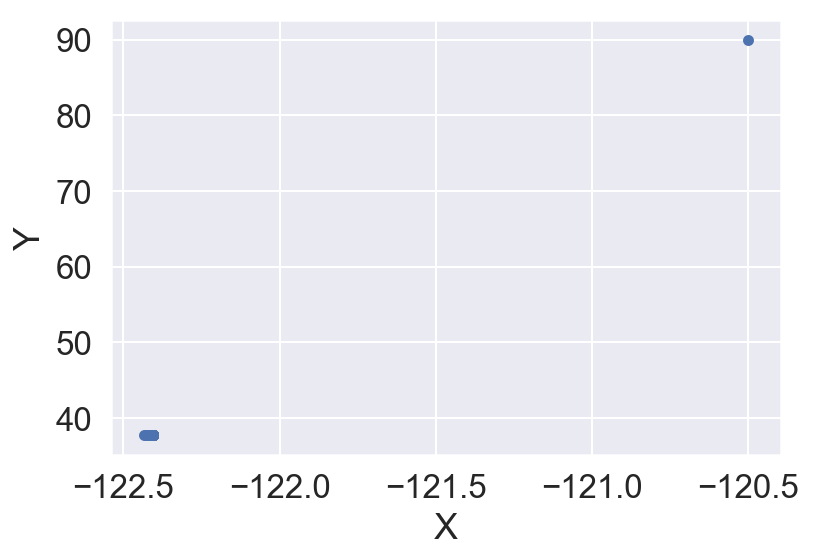

In [119]:
sf_crime[sf_crime['PdDistrict']=='TENDERLOIN'].plot.scatter(x='X',y='Y')

In [117]:
sf_crime.sort_values('Y',ascending=False)

,Category,Descript,PdDistrict,Resolution,Address,X,Y,Year,Month,Day_of_Week,Hour,Time,Date
13250,OTHER OFFENSES,VIOLATION OF MUNICIPAL POLICE CODE,TENDERLOIN,"ARREST, CITED",7THSTNORTH ST / MCALLISTER ST,-120.500000,90.000000,2005,10,Monday,18,18:46:00,2005-10-03
23676,WARRANTS,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",AUSTIN ST / LARKIN ST,-120.500000,90.000000,2003,6,Tuesday,18,18:35:00,2003-06-24
13000,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,RICHMOND,NONE,AVENUE OF THE PALMS / GEARY BL,-120.500000,90.000000,2005,10,Sunday,20,20:00:00,2005-10-23
24964,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,RICHMOND,NONE,0 Block of AVENUE OF THE PALMS,-122.370778,37.814691,2008,1,Thursday,21,21:00:00,2008-01-24
8449,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,SOUTHERN,UNFOUNDED,200 Block of I-80,-122.364937,37.810204,2003,3,Friday,23,23:00:00,2003-03-07
20729,MISSING PERSON,MISSING JUVENILE,SOUTHERN,LOCATED,200 Block of I-80,-122.364937,37.810204,2003,1,Tuesday,18,18:00:00,2003-01-21
19010,LARCENY/THEFT,PETTY THEFT FROM UNLOCKED AUTO,SOUTHERN,NONE,200 Block of I-80,-122.364937,37.810204,2003,4,Tuesday,17,17:00:00,2003-04-15
2235,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,SOUTHERN,NONE,200 Block of I-80,-122.364937,37.810204,2004,11,Monday,12,12:00:00,2004-11-08
22354,OTHER OFFENSES,TRAFFIC VIOLATION,SOUTHERN,"ARREST, CITED",200 Block of I-80,-122.364937,37.810204,2003,11,Saturday,22,22:30:00,2003-11-15
5332,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",SOUTHERN,NONE,200 Block of I-80,-122.364937,37.810204,2004,2,Tuesday,18,18:00:00,2004-02-03


In [138]:
# Could fill these 3 odd co-ordinates with the mean for that PdDistrict, but I don't use it later so won't try
mean_coord = sf_crime.groupby('PdDistrict').mean()
mean_coord

,X,Y,Year,Month,Hour
PdDistrict,,,,,
BAYVIEW,-122.393596,37.737404,2008.467710,6.357730,13.429746
CENTRAL,-122.409743,37.795719,2008.951320,6.423680,13.228135
INGLESIDE,-122.428846,37.726398,2008.625443,6.411348,13.546099
MISSION,-122.419264,37.760096,2008.586358,6.330796,13.367681
NORTHERN,-122.426022,37.803554,2008.564694,6.371261,13.022432
PARK,-122.445150,37.770400,2008.910292,6.432545,13.349096
RICHMOND,-122.468569,37.821022,2008.692668,6.468019,13.439938
SOUTHERN,-122.405264,37.779969,2008.837299,6.547247,13.521867
TARAVAL,-122.477440,37.738202,2008.631929,6.440687,13.506652


### 4. Set up a target and predictor matrix for predicting violent crime vs. non-violent crime vs. non-crimes.

**Non-Violent Crimes:**
- bad checks
- bribery
- drug/narcotic
- drunkenness
- embezzlement
- forgery/counterfeiting
- fraud
- gambling
- liquor
- loitering 
- trespass

**Non-Crimes:**
- non-criminal
- runaway
- secondary codes
- suspicious occ
- warrants

**Violent Crimes:**
- everything else



**What type of model do you need here? What is your baseline accuracy?**

In [124]:
NVC = ['BAD CHECKS', 'BRIBERY', 'DRUG/NARCOTIC', 'DRUNKENNESS',
       'EMBEZZLEMENT', 'FORGERY/COUNTERFEITING', 'FRAUD',
       'GAMBLING', 'LIQUOR LAWS', 'LOITERING', 'TRESPASS', 'OTHER OFFENSES']

NOT_C = ['NON-CRIMINAL', 'RUNAWAY',
         'SECONDARY CODES', 'SUSPICIOUS OCC', 'WARRANTS']

# use a list comprehension to get all the categories in sf_crime['Category'].unique() that are NOT
# in the lists above

VC = [x for x in sf_crime['Category'].unique() if x not in NVC and x not in NOT_C]
VC

['ARSON',
 'LARCENY/THEFT',
 'BURGLARY',
 'VEHICLE THEFT',
 'ASSAULT',
 'MISSING PERSON',
 'VANDALISM',
 'ROBBERY',
 'PROSTITUTION',
 'DISORDERLY CONDUCT',
 'SEX OFFENSES FORCIBLE',
 'STOLEN PROPERTY',
 'DRIVING UNDER THE INFLUENCE',
 'KIDNAPPING',
 'WEAPON LAWS',
 'RECOVERED VEHICLE',
 'EXTORTION',
 'FAMILY OFFENSES',
 'SUICIDE',
 'SEX OFFENSES NON FORCIBLE']

In [127]:
# add a column called 'Type' into your dataframe that stores whether the observation was:
# Non-Violent, Violent, or Non-Crime
# use .map()!


def typecrime(x):
    if x in NOT_C:
        return 'NOT_CRIMINAL'
    if x in NVC:
        return 'NON-VIOLENT'
    if x in VC:
        return 'VIOLENT_CRIME'

sf_crime['Type'] = sf_crime['Category'].map(typecrime)
sf_crime.head()

,Category,Descript,PdDistrict,Resolution,Address,X,Y,Year,Month,Day_of_Week,Hour,Time,Date,Type
0,ARSON,ARSON OF A VEHICLE,BAYVIEW,NONE,0 Block of HUNTERS PT EXPWY EX,-122.376945,37.733018,2003,3,Sunday,23,23:27:00,2003-03-23,VIOLENT_CRIME
1,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,NORTHERN,NONE,0 Block of MARINA BL,-122.432952,37.805052,2006,3,Tuesday,6,06:45:00,2006-03-07,VIOLENT_CRIME
2,NON-CRIMINAL,LOST PROPERTY,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421,2004,3,Saturday,3,03:00:00,2004-03-06,NOT_CRIMINAL
3,BURGLARY,"BURGLARY OF STORE, UNLAWFUL ENTRY",TARAVAL,"ARREST, BOOKED",3200 Block of 20TH AV,-122.475647,37.728528,2011,12,Saturday,12,12:10:00,2011-12-03,VIOLENT_CRIME
4,LARCENY/THEFT,PETTY THEFT OF PROPERTY,NORTHERN,NONE,POLK ST / BROADWAY ST,-122.421772,37.795946,2003,1,Friday,0,00:15:00,2003-01-10,VIOLENT_CRIME


In [130]:
# find the baseline accuracy:
sf_crime['Type'].value_counts(normalize=True)

VIOLENT_CRIME    0.53852
NON-VIOLENT      0.25860
NOT_CRIMINAL     0.20288
Name: Type, dtype: float64

In [131]:
# create a target array with 'Type'
y = sf_crime.pop('Type')

0    VIOLENT_CRIME
1    VIOLENT_CRIME
2     NOT_CRIMINAL
3    VIOLENT_CRIME
4    VIOLENT_CRIME
Name: Type, dtype: object

In [134]:
# create a predictor matrix with 'Day_of_Week','Month','Year','PdDistrict','Hour', and 'Resolution'
X = sf_crime[['Day_of_Week','Month','Year','PdDistrict','Hour','Resolution']]
X.head()

,Day_of_Week,Month,Year,PdDistrict,Hour,Resolution
0,Sunday,3,2003,BAYVIEW,23,NONE
1,Tuesday,3,2006,NORTHERN,6,NONE
2,Saturday,3,2004,SOUTHERN,3,NONE
3,Saturday,12,2011,TARAVAL,12,"ARREST, BOOKED"
4,Friday,1,2003,NORTHERN,0,NONE


In [135]:
# use pd.get_dummies() to dummify your categorical variables
# remember to drop a column!
X = pd.get_dummies(X,drop_first=True)

### 5. Create a train/test/split and standardize the predictor matrices

In [136]:
# create a 50/50 train test split;
# stratify based on your target variable
# use a random state of 2018

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=2018,stratify=y)

In [137]:
# standardise your predictor matrices
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns,index=X_test.index)

### 6. Create a basic Logistic Regression model and use cross_val_score to assess its performance on your training data

In [141]:
# create a default Logistic Regression model and find its mean cross-validated accuracy with your training data
# use 5 cross-validation folds
logistic = LogisticRegression(C=10**10,multi_class='ovr')
logistic.fit(X_train,y_train)
logistic.score(X_train,y_train)

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.63416

In [24]:
# create a confusion matrix
# predictions =
#confusion = confusion_matrix()
# pd.DataFrame(confusion,
#             columns=sorted(y_train.unique()),
#             index=sorted(y_train.unique()))

### 7. Find the optimal hyperparameters (optimal regularization) to predict your crime categories using GridSearchCV.

> **Note:** Gridsearching can be done with `GridSearchCV` or `LogisticRegressionCV`. They operate differently - the gridsearch object is more general and can be applied to any model. The `LogisticRegressionCV` is specific to tuning the logistic regression hyperparameters. I recommend the logistic regression one, but the downside is that lasso and ridge must be searched separately. To start with, use `GridSearchCV`.

**Reference for logistic regression regularization hyperparameters:**
- `solver`: algorithm used for optimization (relevant for multiclass)
    - Newton-cg - Handles Multinomial Loss, L2 only
    - Sag - Handles Multinomial Loss, Large Datasets, L2 Only, Works best on scaled data
    - lbfgs - Handles Multinomial Loss, L2 Only
    - liblinear - Small Datasets, no Warm Starts
- `C`: Regularization strengths (smaller values are stronger penalties)
- `penalty`: `'l1'` - Lasso, `'l2'` - Ridge 

In [25]:
# create a hyperparameter dictionary for a logistic regression

In [26]:
# create a gridsearch object using LogisticRegression() and the dictionary you created above

In [27]:
# fit the gridsearch object on your training data

In [28]:
# print out the best parameters

In [29]:
# print out the best mean cross-validated score

In [30]:
# assign your best estimator to the variable 'best_logreg'

In [31]:
# score your model on your testing data

### 8. Print out a classification report for your best_logreg model

In [32]:
# use your test data to create your classification report
# predictions =
# print(classification_report())

### 9. Explore LogisticRegressionCV.  

With LogisticRegressionCV, you can access the best regularization strength for predicting each class! Read the documentation and see if you can implement a model with LogisticRegressionCV.

In [33]:
# A: